In [1]:
# run the header that sets up the environment

if "already_run" not in globals():
    globals()["already_run"] = True
    
    %run header.ipynb
    load_packages()
    change_wordir()
    colors, colours = colourblind_palette()

#model = "cyclic_2021"
#model = "new_PSI"
model = "latest_dev"

m = load_model(model)

Could not find cannot import name 'dopri5' from 'assimulo.lib' (c:\Users\andre\miniconda3\envs\modelbase.1.30.0\lib\site-packages\assimulo\lib\__init__.py)
Could not find cannot import name 'rodas' from 'assimulo.lib' (c:\Users\andre\miniconda3\envs\modelbase.1.30.0\lib\site-packages\assimulo\lib\__init__.py)
Could not find cannot import name 'odassl' from 'assimulo.lib' (c:\Users\andre\miniconda3\envs\modelbase.1.30.0\lib\site-packages\assimulo\lib\__init__.py)
Could not find ODEPACK functions.
Could not find RADAR5
Could not find GLIMDA.


1.30.0

succesfully loaded latest_dev :D


In [2]:

def pfd_ss_scan(s: object, pfd_values: np.ndarray, y0_loop: dict, debug: bool =False) -> tuple:

    fluxes = {}  # store steady-state fluxes for each pfd value
    concentrations = {}  # store steady-state concentrations for each pfd value
    failed_cases = []

    # Iterate over each pfd value with a progress bar
    for x in tqdm(pfd_values, total=len(pfd_values)):  

        s.initialise(y0_loop)  # Reset the system with the given initial conditions
        s.update_parameter("pfd", x)  # Update the parameter "pfd" to the current value
        
        try:
            t, y = s.simulate_to_steady_state()

            if y is None or len(y) == 0:  # Check for invalid output
                raise ValueError(f"Simulation returned empty result at pfd={x}")

            # Store the final steady-state concentrations
            concentrations[x] = s.get_full_results_array()[-1]

            # Store the final steady-state fluxes
            fluxes[x] = s.model.get_fluxes_array(y=y, t=t)[-1]

            # Update initial conditions for the next iteration
            y0_loop = s.get_new_y0()

        except Exception as e:
            logger.warning(f"Simulation failed at pfd={x}: {e}")
            failed_cases.append(x)

            # Store NaNs for failed cases
            all_compounds = s.model.get_all_compounds()
            rate_names = s.model.get_rate_names()
            concentrations[x] = np.full(len(all_compounds), np.nan)
            fluxes[x] = np.full(len(rate_names), np.nan)

            # If debug mode is enabled, log additional details
            if debug:
                logger.debug(f"Failed pfd={x}. Initial conditions: {y0_loop}")

    # Log summary after execution
    logger.info(f"Simulation completed. {len(failed_cases)} cases failed: {failed_cases}")

    return (
        pd.DataFrame(concentrations, index=s.model.get_all_compounds()).T,  # Convert concentration results to DataFrame
        pd.DataFrame(fluxes, index=s.model.get_rate_names()).T  # Convert flux results to DataFrame
    )


In [3]:
NUM_SCANS = 5
LOW_LIGHT = 40
HIGH_LIGHT = 1750
PFD_VALUES = np.linspace(LOW_LIGHT, HIGH_LIGHT, NUM_SCANS)

y0 = {
    "PQ": 11.248282037382348,       "PC": 1.3639930534269078,       "Fd": 4.207984023619571,
    "ATP": 1.6085042256522668,      "NADPH": 0.45672250689837696,   "H": 0.002174958602661375,
    "LHC": 0.8079188314632375,      "Psbs": 0.9626375680773129,     "Vx": 0.9570474456930378,
    "PGA": 0.6109221284988471,      "BPGA": 0.0003235574325883373,  "GAP": 0.003190323205250446,
    "DHAP": 0.07018710225866034,    "FBP": 0.0015898274733035427,   "F6P": 0.0886998278393475,
    "G6P": 0.20400960399249862,     "G1P": 0.011832557030606641,    "SBP": 0.003215008299488195,
    "S7P": 0.02811069161049136,     "E4P": 0.003523560381569699,    "X5P": 0.006746131132013272,
    "R5P": 0.011299769265221232,    "RUBP": 0.030373422172205858,   "RU5P": 0.004519907641254276,
    "MDA": 2.2718326276618075e-06,
#    "ASC": 9.999997726884683,
    "H2O2": 1.3296482521160688e-06,
    "DHA": 1.2828228406972059e-09,
#    "GSH": 9.999999998752703,
    "GSSG": 6.236645512101874e-10,
    "TR_ox": 0.9,
    "E_inactive": 4.7368421052631575,
    "P700FA": 1.4731,            #eq at pfd 800       #"PSItot": 2.5, (in parameter vector of Matuszynska)
    "P700+FA-": 0.0131,
    "P700FA-": 0.0177,
    "B0": 1,
    "B1": .25,
    "B2": 1,
}

In [ ]:
s = Simulator(m)
c, v = pfd_ss_scan(s, PFD_VALUES, y0, True)

 40%|████      | 2/5 [00:04<00:06,  2.27s/it]

KeyboardInterrupt: 

Exception ignored in: 'assimulo.solvers.sundials.cv_rhs'
Traceback (most recent call last):
  File "c:\Users\andre\miniconda3\envs\modelbase.1.30.0\lib\site-packages\modelbase\ode\models\model.py", line 658, in _get_rhs
    fluxes = self._get_fluxes(fcd=fcd)  # type: ignore
  File "c:\Users\andre\miniconda3\envs\modelbase.1.30.0\lib\site-packages\modelbase\core\ratemixin.py", line 528, in _get_fluxes
    fluxes[name] = float(rate.function(*(args[arg] for arg in rate.args)))
KeyboardInterrupt: 


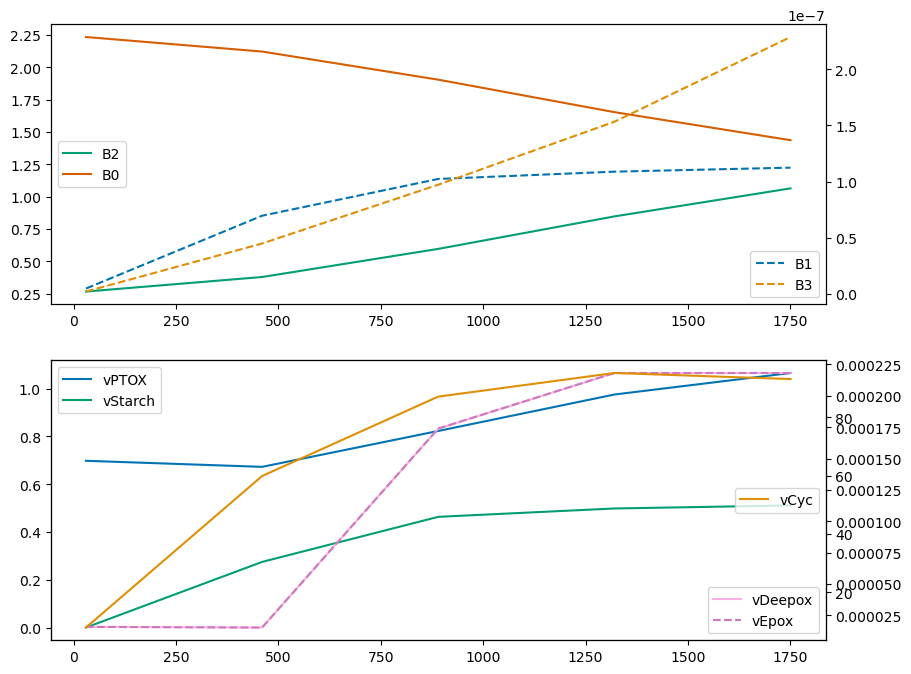

In [ ]:
# PSII states in st.st.

fig, (ax11, ax21) = plt.subplots(2,1,figsize=(10, 8))
ax12 = ax11.twinx()
#ax13 = ax11.twinx()
ax22 = ax21.twinx()
ax23 = ax21.twinx()

ax12.plot(c.loc[:, "B1"], label = "B1", color=colors[0], linestyle='--')
ax12.plot(c.loc[:, "B3"], label = "B3", color=colors[1], linestyle='--')
ax11.plot(c.loc[:, "B2"], label = "B2", color=colors[2])
ax11.plot(c.loc[:, "B0"], label = "B0", color=colors[3])

# vPTOX, vCyc, vStarch, vDeepox, vEpox

ax21.plot(v.loc[:, "vPTOX"], label = "vPTOX", color=colors[0])
ax23.plot(v.loc[:, "vCyc"], label = "vCyc", color=colors[1])
ax21.plot(v.loc[:, "vStarch"], label = "vStarch", color=colors[2])
ax22.plot(v.loc[:, "vDeepox"], label = "vDeepox", color=colors[6], linestyle='-')
ax22.plot(v.loc[:, "vEpox"], label = "vEpox", color=colors[4], linestyle='--')

ax11.legend(loc='center left')
ax12.legend(loc='lower right')
ax21.legend(loc='upper left')
ax22.legend(loc='lower right')
ax23.legend(loc='center right')

plt.show()


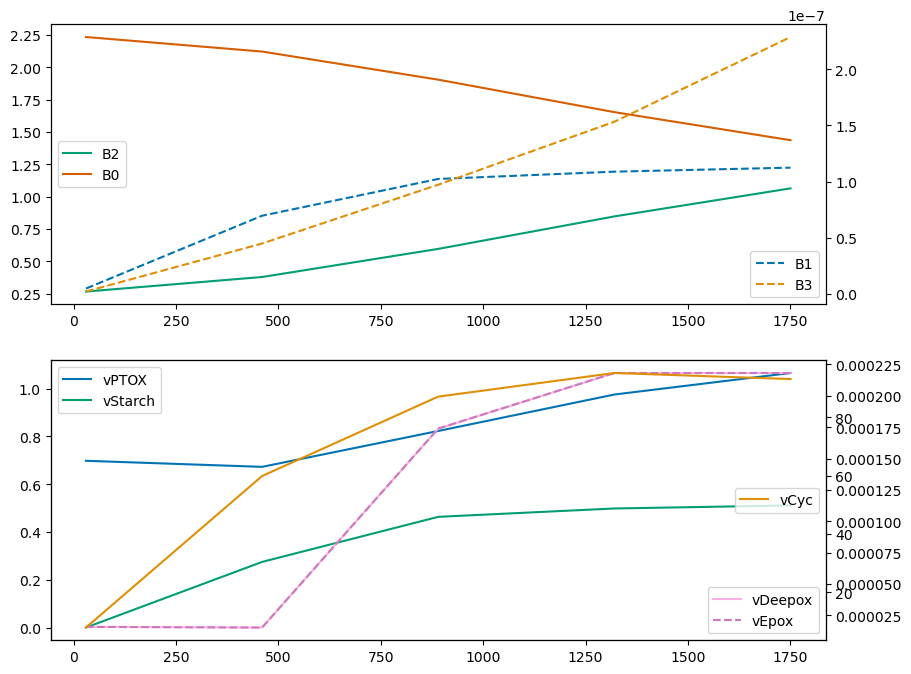

In [39]:
from IPython.display import Image
Image(filename='figures/new_PSI/PSII.png') 

In [40]:
from modelbase.ode import Model
p = {"a": 0.5, "b":1}
m = Model(parameters=p, compounds=["A", "B"])

In [44]:
def power(A, a):
    return a**A

def plus3(x):
    return 1

In [45]:
m.add_reaction(
    rate_name="1",
    function=power,
    stoichiometry={"A": 1},
    args={"A", "a"}
)

# m.add_algebraic_module(
#     module_name="X",
#     function=times,
#     compounds=["A"],
#     derived_compounds=["X"],
#     parameters=["a"],
#     args=["a", "A"]
# )

# m.add_algebraic_module(
#     module_name="Y",
#     function=times,
#     compounds=["X"],
#     derived_compounds=["Y"],
#     parameters=["a"],
# )


<Axes: >

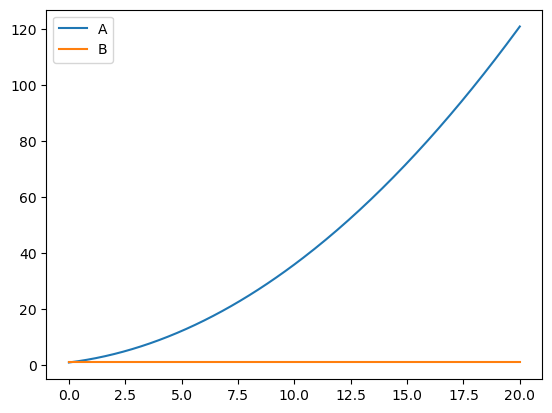

In [46]:
from modelbase.ode import Simulator

s = Simulator(m)
s.initialise({"A":1, "B":1})
t_end = 20
steps_per_second = 10

steps = steps_per_second * t_end

_ = s.simulate(t_end = t_end, steps = steps)
s.get_full_results_df().plot()